In [1]:
from __future__ import division
import sys
import random
import copy
import math
import json

import numpy as np
import pandas as pd
import scipy


%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import seaborn as sns

sys.path.append("../resources/")
import sct_py3
sns.set_style("ticks")
sns.set_context("talk")

output_dir = "out/"
output_suffix = ""
output_formats = [".png", ".pdf"]


mpl.rc('savefig', dpi=300)

def save_figure(fig, name):
    for output_format in output_formats:
        fig.savefig(output_dir + "/" + name + output_suffix + output_format)
    return None

mpl.rc('savefig', dpi=300)

pd.options.mode.chained_assignment = None  # default='warn'


/Users/colleenmclaughlin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_csv('../data/htseq_ORN_nuclei_LogCPM_17plates_addintron_hq50k_neuron2-5.tab.gz',  sep="\t", header=0, index_col=0)
df.shape

(17472, 2829)

In [3]:
df_libs = pd.read_csv('../data/PN_ORN_libs_CNM.csv', sep=",", header=0, index_col=0)
df_libs.head()

,pooled_library,SampleID,Index,num,experiment,plate,well,num_cells,num_mapped_reads,color,genotype,colorHL,label
library,,,,,,,,,,,,,
N447Barcode_701-502,N477,1000100701-A1-flybrain-1,TAAGGCGA-ATAGAGAG,2477.0,13.0,1000100701,A1,1.0,NaN,#a3eb13,nSyb_48h_ORN,#e31a1c,nSyb_48h_ORN_P0
N447Barcode_702-502,N447,1000100701-A2-flybrain-1,CGTACTAG-ATAGAGAG,2478.0,13.0,1000100701,A2,1.0,NaN,#a3eb13,nSyb_48h_ORN,#e31a1c,nSyb_48h_ORN_P0
N447Barcode_703-502,N447,1000100701-A3-flybrain-1,AGGCAGAA-ATAGAGAG,2479.0,13.0,1000100701,A3,1.0,NaN,#a3eb13,nSyb_48h_ORN,#e31a1c,nSyb_48h_ORN_P0
N447Barcode_704-502,N447,1000100701-A4-flybrain-1,TCCTGAGC-ATAGAGAG,2480.0,13.0,1000100701,A4,1.0,NaN,#a3eb13,nSyb_48h_ORN,#e31a1c,nSyb_48h_ORN_P0
N447Barcode_705-502,N447,1000100701-A5-flybrain-1,GGACTCCT-ATAGAGAG,2481.0,13.0,1000100701,A5,1.0,NaN,#a3eb13,nSyb_48h_ORN,#e31a1c,nSyb_48h_ORN_P0


In [4]:
names_ORNs = []
with open ("../resources/names_ORN_hq_24h_adult_lamGFP_noAN.txt") as f:
    for line in f:
        names_ORNs.append(line.rstrip())

In [5]:
# Get names of adult ORNs
selector7 = (df_libs["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P1") 
selector8 = (df_libs["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P2") 
selector9 = (df_libs["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P3") 
selector10 = (df_libs["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P5") 
selector11 = (df_libs["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P6") 
selector12 = (df_libs["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P7") 
selector13 = (df_libs["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P8") 
selector14 = (df_libs["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P9") 
selector15 = (df_libs["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P10") 
selector16 = (df_libs['genotype'] == "ORNnuclei_adult_nSybLam_P2")
selector17 = (df_libs['genotype'] == "ORNnuclei_adult_nSybLam_P3")

ORNs_adult = [x for x in list(df.columns) if ((x in df_libs.loc[selector7].index) 
                      or (x in df_libs.loc[selector8].index) 
                      or (x in df_libs.loc[selector9].index)
                      or (x in df_libs.loc[selector10].index)
                      or (x in df_libs.loc[selector11].index)
                      or (x in df_libs.loc[selector12].index)
                      or (x in df_libs.loc[selector13].index)
                      or (x in df_libs.loc[selector14].index)
                      or (x in df_libs.loc[selector15].index)
                      or (x in df_libs.loc[selector16].index)
                      or (x in df_libs.loc[selector17].index))
                      and  x in names_ORNs]


print('adult ORNs:'), len(ORNs_adult)


adult ORNs:


(None, 1891)

In [6]:
df = df[list(ORNs_adult)]

print ("Adult ORNs:"), df.shape

Adult ORNs:


(None, (17472, 1891))

In [7]:
#open names of all receptors 
antennal_receptors = []
with open("../resources/genes_antennal_OrIrGr.txt") as f:
    for line in f:
        antennal_receptors.append(line.rstrip())
#open names of receptors in adult ORNs >=3 log2CPM+1 in > cells
adult_receptors = []
with open ('../data/Figure5/heatmap/adult_receptors>=3>5cells.txt') as f:
    for line in f:
        adult_receptors.append(line.rstrip())
        
        
print ("antennal receptors:"), len(antennal_receptors), print ('adult receptors:'), len(adult_receptors)

antennal receptors:
adult receptors:


(None, 74, None, 62)

In [8]:
X = df

In [9]:
genes = ['Ir75a','Ir75b', 'Ir75c','Gr21a','Gr63a','Ir64a','Ir92a','Ir84a','Ir62a','Or35a','Ir40a','Ir93a','Ir21a',
        'Gr28b','Gr64f','Or22a','Or22b','Or42b','Or19a','Or19b','Gr93a','Or47b','Or59b','Or13a','Or92a',
         'Or7a','Or9a', 'Or65a','Or65b', 'Or65c', 'Or67d', 'Or85f','Ir76a','Ir51b','Or69a','Or2a','Or98a','Or47a',
         'Or49b','Or23a','Or67c','Ir31a','Ir75d','Gr64a','Or43a', 'Or88a','Or83c', 'Or67b','Or85a','Gr61a',
        'Gr43a','Or43b', 'Or56a','Or85b','Or82a', 'Gr10a', 'Or67a', 'Ir41a','Orco','Ir76b','Ir25a','Ir8a',]



Z = X.loc[genes]
print (Z.shape)

(62, 1891)


[]

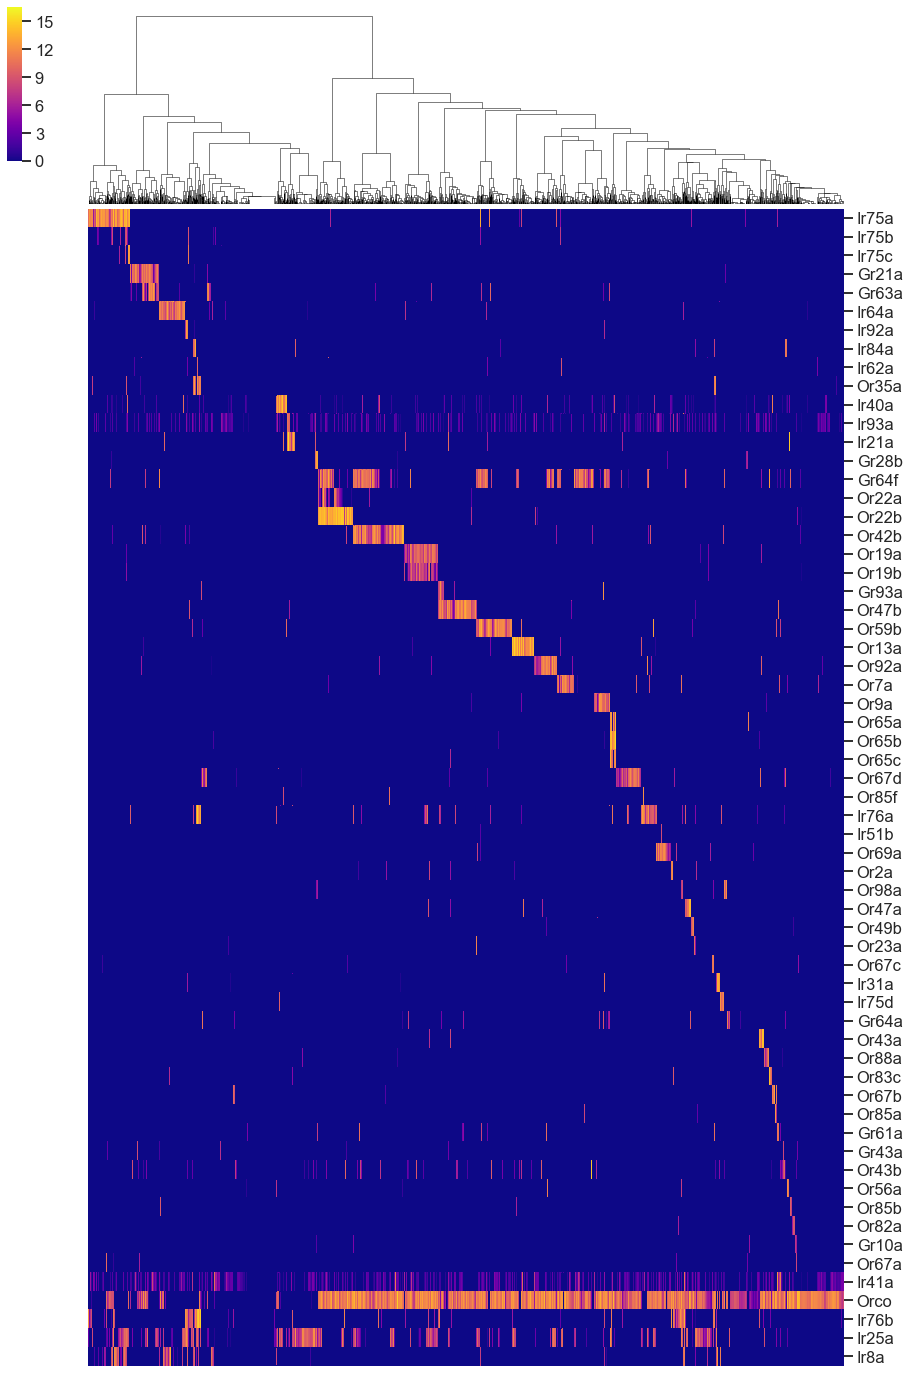

In [10]:
# Calculate clustering and plot
cm = sns.clustermap(Z, method="ward", cmap="plasma", figsize=(15,25),row_cluster=False, col_cluster=True)
plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cm.ax_heatmap.set_ylabel("", )
cm.ax_heatmap.set_xticks([])
cm.ax_heatmap.set_xticklabels([])

In [11]:
print('% of antennal receptors expressed in adult transcriptomes:'), len(adult_receptors)/len(antennal_receptors) * 100

% of antennal receptors expressed in adult transcriptomes:


(None, 83.78378378378379)

# calculate % of neurons expressing a receptor (not co-receptors)

In [12]:
receptors_noco = antennal_receptors.copy()

receptors_noco.remove('Orco')
receptors_noco.remove('Ir25a')
receptors_noco.remove('Ir8a')
receptors_noco.remove('Ir76b')
receptors_noco.remove('Ir93a')

len(receptors_noco)

69

In [13]:
cells_receptor = df.columns[np.where(np.sum(df.loc[receptors_noco] >= 3, axis=0))]
print('% of cells expressing a receptor:'), (len(cells_receptor)/len(df.T.index[:]) * 100)

% of cells expressing a receptor:


(None, 82.65468006345849)